# Random Forest with PCA-Grouped Features
This notebook implements a Random Forest Regressor using PCA-reduced feature sets from four categories:
- **Volume**
- **Volatility**
- **Trend**
- **Momentum**

The model uses a time-wise split and the regular backtesting engine with Bokeh JS output.

## 0) Setup

In [16]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from bokeh.io import output_notebook, show

output_notebook()

# --- Setup correct working directory (ROOT) ---
if os.getcwd().endswith('notebooks'):
    os.chdir('..')

ROOT = os.getcwd()
if ROOT not in sys.path:
    sys.path.insert(0, ROOT)

from src.backtester.data import align_close_prices, load_cleaned_assets
from src.backtester.engine import BacktestConfig, run_backtest
from src.backtester.report import compute_backtest_report
from src.backtester.bokeh_plots import build_interactive_portfolio_layout

FEATURES_PARQUET_PATH = 'dataset/features/all_features.parquet'
TARGET_COL = 'ret_1d'
TARGET_FWD_COL = 'y_ret_1d_fwd'
SEED = 42

Loading BokehJS ...

## 1) Data Loading & Feature Categorization

In [17]:
df = pd.read_parquet(FEATURES_PARQUET_PATH)
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')

# Create Target
df[TARGET_FWD_COL] = df.groupby('Asset_ID', sort=False)[TARGET_COL].shift(-1)
df = df.dropna(subset=[TARGET_FWD_COL])

# Categorize features
volume_features = [
    'log_volume', 'volume_roll_mean_5', 'volume_roll_mean_20', 'volume_roll_mean_60', 
    'volume_roll_std_5', 'volume_roll_std_20', 'volume_roll_std_60', 
    'volume_zscore_5', 'volume_zscore_20', 'volume_zscore_60', 
    'volume_minmax_20', 'obv', 'obv_roc_10', 'wrobv_20', 'ad_line'
]
volatility_features = [
    'logret_roll_var_5', 'logret_roll_var_10', 'logret_roll_var_20', 'logret_roll_var_60', 
    'logret_roll_std_5', 'logret_roll_std_10', 'logret_roll_std_20', 'logret_roll_std_60', 
    'atr_14', 'realized_vol_20', 'bb_bb_bandwidth'
]
trend_features = [
    'sma_20', 'sma_50', 'ha_ha_open', 'ha_ha_high', 'ha_ha_low', 'ha_ha_close', 
    'sma_ratio_20', 'ema_ratio_20', 'bb_bb_mid', 'bb_bb_upper', 'bb_bb_lower', 
    'bb_bb_percent_b', 'adx_plus_di', 'adx_minus_di', 'adx_adx', 'adx_adx_raw', 
    'aroon_aroon_up', 'aroon_aroon_down', 'ichimoku_ichimoku_conv', 
    'ichimoku_ichimoku_base', 'ichimoku_ichimoku_span_a', 'ichimoku_ichimoku_span_b', 
    'ichimoku_ichimoku_lagging', 'bos', 'choch', 'mss'
]
momentum_features = [
    'rsi_14', 'macd_macd', 'macd_macd_signal', 'macd_macd_hist', 
    'rmacd_12_26_9', 'stoch_stoch_k', 'stoch_stoch_d', 'roc_10', 'cci_20'
]

all_buckets = {
    'Volume': volume_features,
    'Volatility': volatility_features,
    'Trend': trend_features,
    'Momentum': momentum_features
}

# Verify if all exist
for name, cols in all_buckets.items():
    missing = [c for c in cols if c not in df.columns]
    if missing:
        print(f'Warning: {name} missing {missing}')
        all_buckets[name] = [c for c in cols if c in df.columns]

# Time-wise split
cutoff_date = '2023-01-01'
df_train = df[df.index < cutoff_date].copy()
df_test = df[df.index >= cutoff_date].copy()

print(f'Train range: {df_train.index.min()} to {df_train.index.max()}')
print(f'Test range: {df_test.index.min()} to {df_test.index.max()}')

Train range: 2016-01-25 00:00:00 to 2022-12-30 00:00:00
Test range: 2023-01-03 00:00:00 to 2026-01-15 00:00:00


## 2) Stepwise PCA

In [18]:
def apply_pca_to_bucket(df_tr, df_te, cols, n_comp=3):
    # Impute and Scale first
    pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=n_comp))
    ])
    
    X_tr = df_tr[cols].replace([np.inf, -np.inf], np.nan)
    X_te = df_te[cols].replace([np.inf, -np.inf], np.nan)
    
    pca_tr = pipe.fit_transform(X_tr)
    pca_te = pipe.transform(X_te)
    
    evr = pipe.named_steps['pca'].explained_variance_ratio_
    print(f'Explained Variance: {evr.sum():.2%}')
    
    return pca_tr, pca_te, pipe

pca_train_list = []
pca_test_list = []
fitted_pca_pipes = {}

for bucket_name, cols in all_buckets.items():
    print(f'\nProcessing Bucket: {bucket_name}')
    tr_res, te_res, pipe = apply_pca_to_bucket(df_train, df_test, cols, n_comp=3)
    pca_train_list.append(tr_res)
    pca_test_list.append(te_res)
    fitted_pca_pipes[bucket_name] = (pipe, cols)

X_train_pca = np.hstack(pca_train_list)
X_test_pca = np.hstack(pca_test_list)
y_train = df_train[TARGET_FWD_COL]
y_test = df_test[TARGET_FWD_COL]

print(f'\nFinal feature shape: {X_train_pca.shape}')


Processing Bucket: Volume
Explained Variance: 77.63%

Processing Bucket: Volatility
Explained Variance: 87.80%

Processing Bucket: Trend
Explained Variance: 81.35%

Processing Bucket: Momentum
Explained Variance: 87.46%

Final feature shape: (174800, 12)


## 2.1) PCA Explained Variance & Loadings

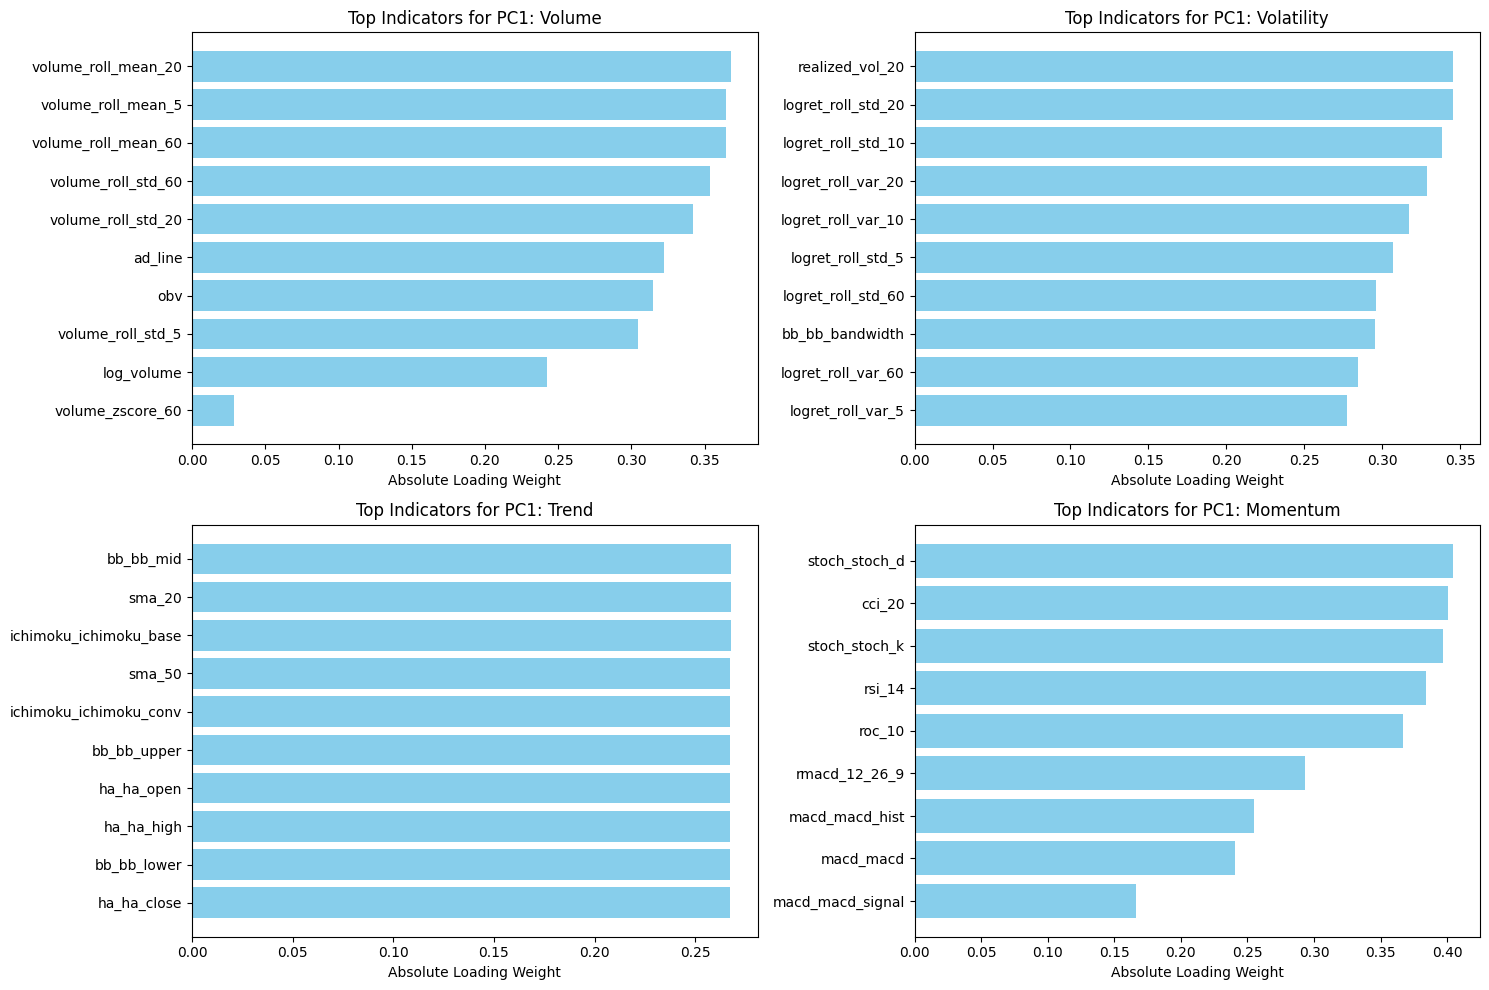

Most explainable indicator for Volume: volume_roll_mean_20
Most explainable indicator for Volatility: logret_roll_std_20
Most explainable indicator for Trend: bb_bb_mid
Most explainable indicator for Momentum: stoch_stoch_d


In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
for i, (name, (pipe, cols)) in enumerate(fitted_pca_pipes.items()):
    pca = pipe.named_steps['pca']
    # Get absolute loadings for PC1
    loadings = np.abs(pca.components_[0])
    top_idx = np.argsort(loadings)[-10:]
    top_features = [cols[j] for j in top_idx]
    top_loadings = loadings[top_idx]
    
    plt.subplot(2, 2, i+1)
    plt.barh(top_features, top_loadings, color='skyblue')
    plt.title(f'Top Indicators for PC1: {name}')
    plt.xlabel('Absolute Loading Weight')
    
plt.tight_layout()
plt.show()

for name, (pipe, cols) in fitted_pca_pipes.items():
    pca = pipe.named_steps['pca']
    loadings = np.abs(pca.components_[0])
    top_feat = cols[np.argmax(loadings)]
    print(f'Most explainable indicator for {name}: {top_feat}')

## 3) Random Forest Model

In [20]:
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=10,
    min_samples_leaf=50,
    n_jobs=-1,
    random_state=SEED
)

print('Training Random Forest...')
rf.fit(X_train_pca, y_train)

pred_test = rf.predict(X_test_pca)
df_test['y_pred'] = pred_test

from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, pred_test))
print(f'Test RMSE: {rmse:.6f}')

Training Random Forest...
Test RMSE: 0.017685


## 4) Backtesting with Bokeh

In [21]:
test_syms = df_test['Asset_ID'].unique()
assets_dict = load_cleaned_assets(symbols=test_syms)
close_prices = align_close_prices(assets_dict)

def run_ml_backtest(preds_col):
    # Prepare weights: Top 5 assets per day based on predicted returns
    w = df_test.pivot(columns='Asset_ID', values=preds_col).reindex(close_prices.index).fillna(0)
    w_rank = w.rank(axis=1, ascending=False)
    w_final = ((w_rank <= 5) & (w > 0)).astype(float)
    w_final = w_final.div(w_final.sum(axis=1), axis=0).fillna(0)

    config = BacktestConfig(rebalance='D', initial_equity=1_000_000, transaction_cost_bps=5.0)
    res = run_backtest(close_prices, w_final, config)
    report = compute_backtest_report(result=res, close_prices=close_prices)
    return res, report, w_final

res, report, weights = run_ml_backtest('y_pred')
display(report)

# Bokeh Visualization
# Create synthetic market OHLCV for the proxy view
market_ohlcv = pd.DataFrame({
    'Open': close_prices.mean(axis=1),
    'High': close_prices.mean(axis=1),
    'Low': close_prices.mean(axis=1),
    'Close': close_prices.mean(axis=1),
    'Volume': pd.Series(0, index=close_prices.index)
})

layout = build_interactive_portfolio_layout(
    market_ohlcv=market_ohlcv,
    equity=res.equity,
    returns=res.returns,
    weights=weights,
    turnover=res.turnover,
    costs=res.costs,
    close_prices=close_prices,
    title='RF-PCA Strategy Portfolio Output'
)
show(layout)

Start                         2023-01-03 00:00:00
End                           2026-01-16 00:00:00
Duration                       1109 days 00:00:00
Initial Equity                           999500.0
Final Equity                       2152021.721414
Equity Peak                        2272809.230218
Total Return [%]                       115.309827
CAGR [%]                                28.868597
Volatility (ann) [%]                    27.554454
Sharpe                                   1.055567
Sortino                                  1.839131
Max Drawdown [%]                       -29.149494
Calmar                                   0.990364
Best Day [%]                            16.650574
Worst Day [%]                           -8.909668
Avg Gross Exposure                       0.999002
Avg Net Exposure                         0.999002
Exposure Time [%]                       99.868938
Rebalance Days                                763
Total Turnover                   739976539.195652
